<a href="https://colab.research.google.com/github/moreHS/Face_swap/blob/main/Face_swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content
!git clone https://github.com/ndb796/motion-cosegmentation

/content
Cloning into 'motion-cosegmentation'...
remote: Enumerating objects: 87, done.
remote: Total 87 (delta 0), reused 0 (delta 0), pack-reused 87
Unpacking objects: 100% (87/87), done.


In [ ]:
%cd motion-cosegmentation

/content/motion-cosegmentation


In [ ]:
# google drive mount로 pre-trained weight 사용
from google.colab import drive
drive.mount('/content/drive')

# import gdown

# # 다운로드받을 파일이 존재하는 URL
# url = 'https://drive.google.com/uc?id=1Asw3DWhdtN4xNaQ9KNfURjaHTyf129hi'

# # 저장할 파일 이름
# output = 'vox-first-order.pth.tar'
# gdown.download(url, output, quiet=False)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Asw3DWhdtN4xNaQ9KNfURjaHTyf129hi 



In [ ]:
# 테스트에 사용될 데이터들 google drive로 참조하도록 변경

# import gdown

# 다운로드받을 파일이 존재하는 URL
# url = 'https://drive.google.com/uc?id=1_9AY3IirN0ipIeHp6myqWdqWFVKS9eWI'
# output = 'source.png'
# gdown.download(url, output, quiet=False)

# 다운로드받을 파일이 존재하는 URL
# url = 'https://drive.google.com/uc?id=1NGZBp3nslrfruZ7Tyin10j6KzYdDNVQO'
# output = 'target.mp4'
# gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1NGZBp3nslrfruZ7Tyin10j6KzYdDNVQO
To: /content/motion-cosegmentation/target.mp4
100%|██████████| 41.6k/41.6k [00:00<00:00, 33.0MB/s]


'target.mp4'

In [ ]:
import imageio
from skimage.transform import resize

# 이미지 불러오기
source_image = imageio.imread('/content/drive/MyDrive/sorce.jpg')

# 동영상 불러오기
reader = imageio.get_reader('/content/drive/MyDrive/target.mp4') # 동영상 리더(reader) 객체 초기화
fps = reader.get_meta_data()['fps']
frames = [] # 동영상의 모든 프레임을 담을 객체
for im in reader:
    frames.append(im)
reader.close()

# 이미지와 동영상을 (256 X 256) 해상도로 변경
source_image = resize(source_image, (256, 256))[..., :3] # 알파(alpha) 값이 있다면 제거
frames = [resize(frame, (256, 256)) for frame in frames]

# 해상도 확인하기
print('이미지 해상도:', source_image.shape)
print('동영상 해상도:', frames[0].shape)

이미지 해상도: (256, 256, 3)
동영상 해상도: (256, 256, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# 이미지와 동영상을 함께 출력하는 메서드
def display(source_image, frames, predictions=None):
    fig = plt.figure(figsize=(8 + 4 * (predictions is not None), 4)) # 하나의 그림(figure) 생성
    images = []
    for i in range(len(frames)):
        cols = [source_image] # 왼쪽에는 소스 이미지(image)
        cols.append(frames[i]) # 오른쪽에는 현재의 비디오 프레임(frame)
        if predictions is not None: # 예측 결과(prediction)가 있는 경우에는 함께 출력
            cols.append(predictions[i])
        image = plt.imshow(np.concatenate(cols, axis=1), animated=True) # 가로 너비(width)를 기준으로 합치기
        images.append([image])

    plt.close()
    ani = animation.ArtistAnimation(fig, images, interval=50, repeat_delay=1000) # 애니메이션(animation) 객체 생성
    return ani

HTML(display(source_image, frames).to_html5_video()) # HTML 비디오(video) 형식으로 화면에 출력

In [ ]:
from part_swap import load_checkpoints

reconstruction_module, segmentation_module = load_checkpoints(config='config/vox-256-sem-10segments.yaml', checkpoint='/content/drive/MyDrive/ch2_2_vox-first-order.pth.tar', blend_scale=0.125, first_order_motion_model=True)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Segmentation part initialized at random.


In [ ]:
# 얼굴 파싱(face parsing)을 위한 라이브러리 불러오기
!git clone https://github.com/ndb796/face-makeup.PyTorch face_parsing

from part_swap import load_face_parser

face_parser = load_face_parser(cpu=False)

Cloning into 'face_parsing'...
remote: Enumerating objects: 62, done.
remote: Total 62 (delta 0), reused 0 (delta 0), pack-reused 62
Unpacking objects: 100% (62/62), done.


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

19
마스크 차원: (256, 256, 19)
19
마스크 차원: (256, 256, 19)


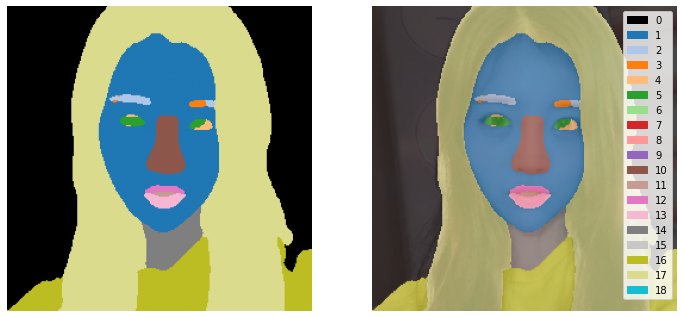

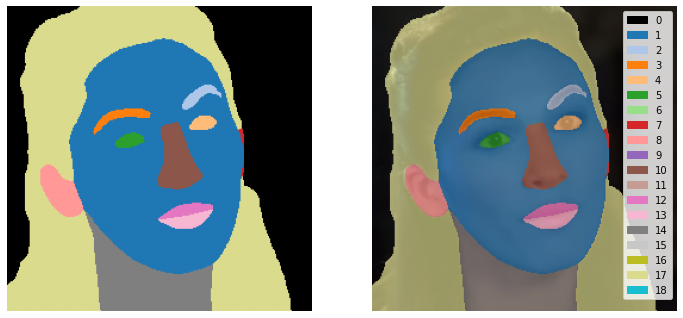

In [ ]:
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore") # 오래 된(deprecated) 코드 경고 메시지 보이지 않도록 하기


# 파싱 네트워크(parsing network)를 이용해 얼굴을 여러 부분으로 분할(segmentation)하여 시각화
def visualize_segmentation(image, network, supervised=False, hard=True, colormap='gist_rainbow'):
    # 네트워크를 이용해 마스크 예측(prediction)
    with torch.no_grad():
        # 이미지의 형태를 바꾸어 PyTorch의 Tensor 형태로 변경: [batch_size, channel, height, width]
        input = torch.tensor(image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2).cuda()
        input = F.interpolate(input, size=(512, 512))
        input = (input - network.mean) / network.std
        mask = torch.softmax(network(input)[0], dim=1) # 네트워크에 입력하여 마스크(mask) 확인
        mask = F.interpolate(mask, size=image.shape[:2]) # 마스크와 이미지의 크기를 동일하도록

    if hard:
        mask = (torch.max(mask, dim=1, keepdim=True)[0] == mask).float()

    # 색상 마스크(color mask) 만들기
    colormap = plt.get_cmap(colormap)
    num_segments = mask.shape[1]
    print(num_segments)
    mask = mask.squeeze(0).permute(1, 2, 0).cpu().numpy() # 이미지의 형태 변경: [height, width, channel]
    color_mask = 0
    patches = []

    # 마스크 차원 출력
    print('마스크 차원:', mask.shape)

    # 세그먼트(segment)의 개수만큼 반복하며 각각 다른 색상 적용
    for i in range(num_segments):
        if i != 0:
            color = np.array(colormap((i - 1) / (num_segments - 1)))[:3]
        else:
            color = np.array((0, 0, 0))
        patches.append(mpatches.Patch(color=color, label=str(i)))
        color_mask += mask[..., i:(i + 1)] * color.reshape(1, 1, 3)
    
    # 두 장의 이미지가 담길 수 있는 그림(figure) 생성
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(color_mask)
    ax[1].imshow(0.3 * image + 0.7 * color_mask)
    ax[1].legend(handles=patches)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

visualize_segmentation(source_image, face_parser, supervised=True, hard=True, colormap='tab20')

visualize_segmentation(frames[0], face_parser, supervised=True, hard=True, colormap='tab20')

In [ ]:
# 결과 영상을 만들기 위한 라이브러리 불러오기
from part_swap import make_video

In [ ]:
# make_video 메서드를 이용해 헤어 스타일만 교체
predictions = make_video(swap_index=[17], source_image=source_image,
                         target_video=frames, use_source_segmentation=True, segmentation_module=segmentation_module,
                         reconstruction_module=reconstruction_module, face_parser=face_parser)

HTML(display(source_image, frames, predictions).to_html5_video())

100%|██████████| 109/109 [00:31<00:00,  3.46it/s]


In [ ]:
# make_video 메서드를 이용해 전체 얼굴을 통째로 교체
predictions = make_video(swap_index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], source_image=source_image,
                         target_video=frames, use_source_segmentation=True, segmentation_module=segmentation_module,
                         reconstruction_module=reconstruction_module, face_parser=face_parser)

HTML(display(source_image, frames, predictions).to_html5_video())

100%|██████████| 109/109 [00:31<00:00,  3.46it/s]
